<a href="https://colab.research.google.com/github/rajibmondal/nlp-tutorial/blob/master/Amazon_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Amazon reviews polarity dataset is constructed by taking review score 1 and 2 as negative, and 4 and 5 as positive. Samples of score 3 is ignored. In the dataset, class 1 is the negative and class 2 is the positive. Each class has 1,800,000 training samples and 200,000 testing samples.

The files train.csv and test.csv contain all the training samples as comma-sparated values. There are 3 columns in them, corresponding to class index (1 or 2), review title and review text. The review title and text are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".

Load some awesome stuff

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.text import *
from fastai.callbacks import *

This block of code links your google drive to the your colab notebook

In [0]:
import os
from google.colab import drive
drive.mount('/content/drive')
root_dir = Path('/content/drive/My Drive')
if not os.path.isdir(root_dir/'Amazon_Sentiment'):
  base_dir = root_dir/'Amazon_Sentiment2'
  base_dir.mkdir(parents=True, exist_ok=True)
else:
  base_dir = root_dir/'Amazon_Sentiment2' 
base_dir

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


PosixPath('/content/drive/My Drive/Amazon_Sentiment2')

In [0]:
# check if the dirctory exists if not make it
if not os.path.isdir(base_dir/'dataset'): (base_dir/'dataset').mkdir(exist_ok=True, parents=True)
data_dir = base_dir/'dataset'
data_dir

PosixPath('/content/drive/My Drive/Amazon_Sentiment2/dataset')

Download the dataset from [Amazon reviews](https://s3.amazonaws.com/fast-ai-nlp/amazon_review_polarity_csv.tgz) into your google drive

In [0]:
!wget https://s3.amazonaws.com/fast-ai-nlp/amazon_review_polarity_csv.tgz -P '/content/drive/My Drive/Amazon_Sentiment/dataset'

--2020-01-26 12:48:12--  https://s3.amazonaws.com/fast-ai-nlp/amazon_review_polarity_csv.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.207.237
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.207.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 688339454 (656M) [application/x-tar]
Saving to: ‘/content/drive/My Drive/Amazon_Sentiment/dataset/amazon_review_polarity_csv.tgz.2’

amazon_review_polar 100%[===================>] 656.45M  14.5MB/s    in 48s     

2020-01-26 12:49:01 (13.6 MB/s) - ‘/content/drive/My Drive/Amazon_Sentiment/dataset/amazon_review_polarity_csv.tgz.2’ saved [688339454/688339454]



In [0]:
os.chdir(data_dir)
!tar -xf '/content/drive/My Drive/Amazon_Sentiment/dataset/amazon_review_polarity_csv.tgz'

In [0]:
data_dir.ls()

[PosixPath('/content/drive/My Drive/Amazon_Sentiment2/dataset/amazon_review_polarity_csv')]

In [0]:
tmp_root = (data_dir/'amazon_review_polarity_csv')
tmp_root.ls()

[PosixPath('/content/drive/My Drive/Amazon_Sentiment2/dataset/amazon_review_polarity_csv/readme.txt'),
 PosixPath('/content/drive/My Drive/Amazon_Sentiment2/dataset/amazon_review_polarity_csv/test.csv'),
 PosixPath('/content/drive/My Drive/Amazon_Sentiment2/dataset/amazon_review_polarity_csv/train.csv')]

View what is inside the train and test dataset csv files

In [0]:
def read_csv(path: Path, names :List[str]=['class', 'review_title', 'review']):
  df = pd.read_csv(path, header=None, names=names)
  # review_1 = df[['rating', 'review']]
  # review_2 = df[['rating', 'review_1']].rename(columns={'review_1':'review'})
  # return pd.concat([review_1, review_2])
  return df

In [0]:
train = read_csv(tmp_root/'train.csv')
train = train.loc[:1000000, :].copy()
train.head()

,class,review_title,review
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [0]:
test = read_csv(tmp_root/'test.csv')
test.head()

,class,review_title,review
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


I noticed that the train and test sets has some missing values so i had to remove them. Neural nets do not like missing values in a dataset so the databunch creating will throw an error.

In [0]:
train_no_na = train.loc[~train.review.isna()]
test_no_na = test.loc[~test.review.isna()]

In [0]:
np.random.seed(2)
bs = 16

In [0]:
train_no_na.iloc[0]

class                                                           2
review_title                       Stuning even for the non-gamer
review          This sound track was beautiful! It paints the ...
Name: 0, dtype: object

In [0]:
len(train_no_na)

In [0]:
len(test_no_na)

The size of the databunch is atleast 2GB so i had to reduce the size of the training corpus by 30% so that it'll fit into the RAM and get serialized without crashing the session due to an out of memory(OOM) error.

In [0]:
train_no_na_70_pct = train_no_na[:(int(0.7*len(train_no_na)))]

In [0]:
lm_data = (TextList.from_df(train_no_na_70_pct, cols=1)
                   .split_by_rand_pct(0.1)
                   .label_for_lm()
                   .databunch(bs=bs))

Save the language model databunch os we won't have to go through this process again

In [0]:
# specify the path to save the data
if not os.path.isdir(base_dir/'data'):  (base_dir/'data').mkdir(parents=True, exist_ok=True); data_dir = (base_dir/'data') 
else: data_dir = base_dir/'data'
data_dir

In [0]:
lm_data.save(data_dir/'lm_data.pkl')

In [0]:
lm_data = load_data(data_dir, 'lm_data.pkl', bs=bs)

In [0]:
lm_data.show_batch()

##Language Model Training

### Use the frozen pretrained weights to create a baseline language model then finetune the pretrained weights on the new dataset

We'll be using tranfer learning using weights trained on the wiki-text dataset. We'll also be using dropout to decrease overfitting

In [0]:
lm_learner = language_model_learner(lm_data, AWD_LSTM, drop_mult=0.3)

In [0]:
lm_learner.lr_find()

Min numerical gradient: 1.32E-06
Min loss divided by 10: 8.32E-03


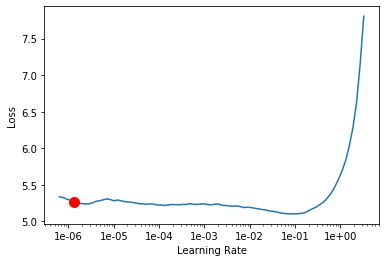

In [0]:
lm_learner.recorder.plot(suggestion=True)

Min numerical gradient: 1.32E-06
Min loss divided by 10: 8.32E-03


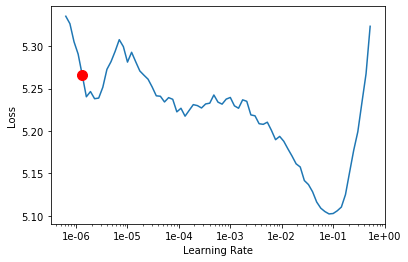

In [0]:
lm_learner.recorder.plot(skip_end=15, suggestion=True)

Training the network will update only the parameters of only the last few layers. These last few layers are that learn the features of the `data_lm` using the pretrained weights trained on wiki-text

In [0]:
lm_learner.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time


Buffered data was truncated after reaching the output size limit.

Export the language model so that it'll be saved in a `.pkl` format. I've found this can be a bit time consuming to load than using the `.save` method that saves it in a `.pth` format

In [0]:
# specify the path to save the models
if not os.path.isdir(base_dir/'models'):  (base_dir/'models').mkdir(parents=True, exist_ok=True); model_dir = base_dir/'models'  
else: model_dir = base_dir/'models'
model_dir

PosixPath('/content/drive/My Drive/Amazon_Sentiment/models')

In [0]:
lm_learner.export(model_dir/'lm_head.pkl')

##Fine-Tune the language model

load the learner. This just loads the weights that the learner learnt but it doesn't load the data being learnt with it

In [0]:
lm_learner = load_learner(model_dir, 'lm_head.pkl')

Load the data being learnt

In [0]:
lm_learner.data = lm_data

Unfreeze all the layers of the network so we can update all their parameters during training

In [0]:
lm_learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 2.51E-04


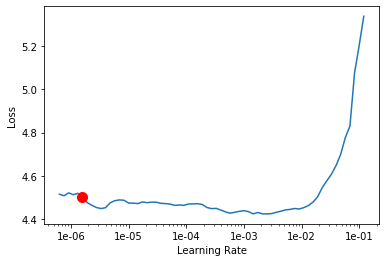

In [0]:
lm_learner.lr_find()
lm_learner.recorder.plot(skip_end=15, suggestion=True)

Use a callback to save the model after every epoch

In [0]:
# change the directory to where we want the callback to save the every epoch model
os.chdir(model_dir)

In [0]:
callbacks = [SaveModelCallback(lm_learner, every='epoch', monitor='valid_loss', name='finetuned_lm')]

In [0]:
lm_learner.fit_one_cycle(10, 1e-3, moms=(0.8, 0.7), callbacks= callbacks)

epoch,train_loss,valid_loss,accuracy,time
0,3.868877,3.792745,0.338294,3:52:22


Each epoch was taking to long so i cancelled it after the first. Thankfully we have callbacks that save the model after every epoch :). We can jsut load the model after the last saved epoch

In [0]:
lm_learner.load('finetuned_lm_0')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (4535952 items)
x: LMTextList
xxbos xxmaj xxunk even for the non - gamer,xxbos xxmaj the best soundtrack ever to anything .,xxbos xxmaj amazing !,xxbos xxmaj remember , xxmaj pull xxmaj your xxmaj jaw xxmaj off xxmaj the xxmaj floor xxmaj after xxmaj hearing it,xxbos an absolute masterpiece
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (503994 items)
x: LMTextList
xxbos easy to use and good clarity,xxbos xxmaj the new xxmaj rufio album is awesome ! xxmaj but without a doubt i love both of their albums equally ! xxmaj if you like punk rock then you will love xxmaj rufio ! i ca n't wait till they have another concert in xxmaj jacksonville ! xxmaj oh yeah and if ya do n't get the album i 'll hunt ya down and beat you with a very large stick !,xxbos i was so excited about getting this movie at such a good deal on the price , because i love musicals . xxmaj when we watched the movie , i was shocked to find that they used the xxmaj lor

## Language Model Prediction

In [0]:
WORD = 'Book'
# how many next words do we want to predict
NUM_OF_NEW_WORDS = 20
# Specify the number of sentences that the model can make using the WORD as a starter
NUM_OF_SENTENCES = 2

In [0]:
print('\n'.join(lm_learner.predict(WORD, NUM_OF_NEW_WORDS, temperature = 0.6) for _ in range(NUM_OF_SENTENCES)))

Book was ok but the book was just not well written . Also the book was mostly written by a
Book Sucks xxbos This book is a waste of time and money . It is not worth the


We can see that the language model we have has learnt how to speak in 'Amazon review English'

We can then export the encoder from the finetuned language model

In [0]:
lm_learner.save_encoder('lm_fine_tuned_enc')

## Let's Build the Classifier

In [0]:
len(lm_data.vocab.itos)

60000

We have to sort our testing and training dataframes

In [0]:
train = pd.read_csv(tmp_root/'train.csv', header=None, names = ['pos/neg', 'title', 'review'])
train.head()

,pos/neg,title,review
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [0]:
len(train)

3600000

ensure to use the same vocab when building the IteList

In [0]:
clas_data = (TextList.from_df(train_no_na, cols = [1], vocab=lm_data.vocab))
clas_data

TypeError: ignored